In [1]:
import numpy as np
from scipy import fft
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from multiprocessing import Pool

import torch
import torchvision


In [2]:
resolution=256 #space resolution
v_filename='/home/costa/project_1/data_dft/speckleR.dat'
n_filename='/home/costa/project_1/data_dft/speckleF.dat'
E_filename='/home/costa/project_1/data_dft/evalues.dat'

N_data=150000

train_fraction=0.95
N_train=int(train_fraction*N_data)


In [4]:
f=[v_filename,n_filename,E_filename]

pool=Pool(3)

results=pool.map(read_file,f)

x_v,n,E=results

##################################

#x_v=np.einsum('ij->ji',x_v)

#x,v=np.asarray(x_v)

In [3]:
def read_file(f):

    if (f==n_filename) or (f==E_filename):

        n=np.genfromtxt(f,usecols=1)

        return n
    else:

        v=np.genfromtxt(f)

        return v


In [7]:
print(x_v.shape, n.shape, E.shape)

(38400000, 2) (38400000,) (150000,)


In [8]:
fst_arr = x_v[0:256,0]
snd_arr = x_v[256:256+256,0]
print(np.all(fst_arr==snd_arr))
print(fst_arr[:3], "\n" ,snd_arr[:3])

True
[0.      0.05469 0.1094 ] 
 [0.      0.05469 0.1094 ]


In [9]:
x_axis = x_v[:256, 0]
speckle_real = np.split(x_v[:,1], int(x_v.shape[0]/256))

In [10]:
len(speckle_real)
print(speckle_real[0].shape)

(256,)


In [11]:
speckle_fou = np.split(n, int(n.shape[0]/256))
print(len(speckle_fou), speckle_fou[0].shape)

150000 (256,)


Zero freq: 3.9999999877691153  (4.000134296875-0j)  is zero: (0.00011498933475929706+9.362673535914348e-06j)


In [16]:
data = np.load('dataset.npz')
#print(data['speckle_r'].shape)
data.files

['x_axis', 'speckle_r', 'speckle_f', 'energy']

In [18]:
from dataload import pltgrid

keys = data.files[1:2]
idx = np.arange(4)
images = np.empty((len(keys), len(idx)))
images = data[key for key in keys][idx]

#pltgrid(6, data, ['speckle_r', 'speckle_f'])

SyntaxError: invalid syntax (<ipython-input-18-0908c3c51d51>, line 6)

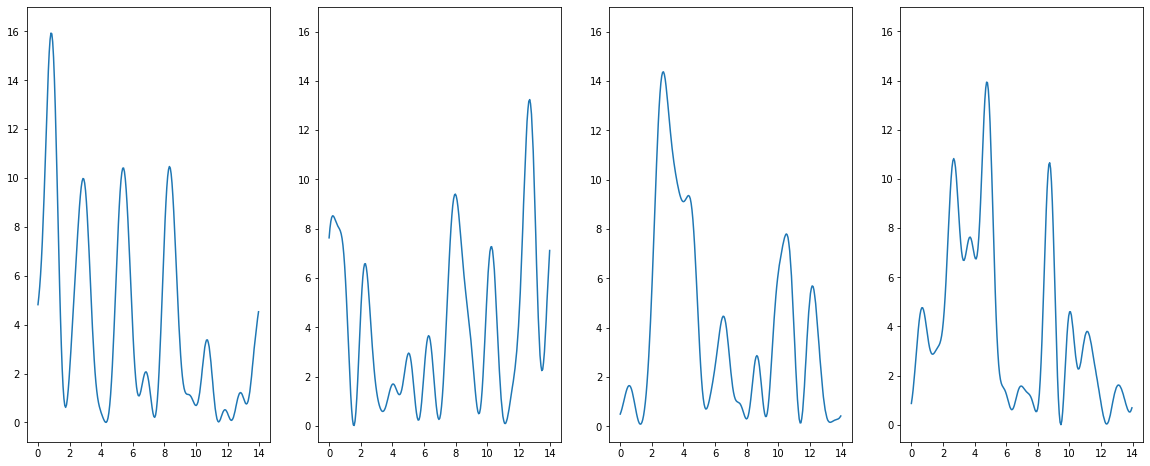

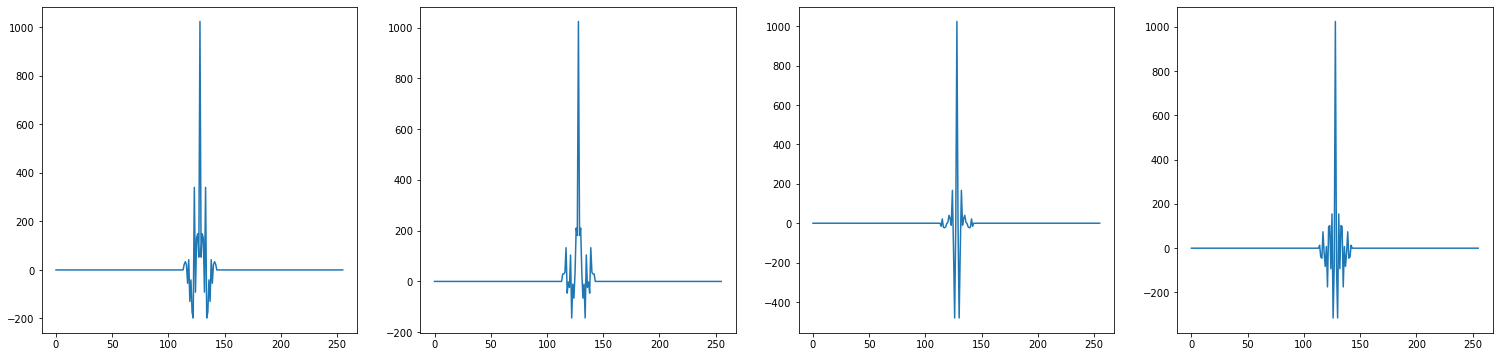

In [28]:
speckle_real = data['speckle_r']
speckle_fou = data['speckle_f']
x_axis = data['x_axis']

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20,8))
ax1.plot(x_axis, speckle_real[2])
ax1.set_ylim(top=17)
ax2.plot(x_axis, speckle_real[1])
ax2.set_ylim(top=17)
ax3.plot(x_axis, speckle_real[3])
ax3.set_ylim(top=17)
ax4.plot(x_axis, speckle_real[4])
ax4.set_ylim(top=17)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(26,6))
ax1.plot(fft.fftshift(fft.fft(speckle_real[2])))
#ax1.set_ylim(top=17)
ax2.plot(fft.fftshift(fft.fft(speckle_real[1])))
#ax2.set_ylim(top=17)
ax3.plot(fft.fftshift(fft.fft(speckle_real[3])))
#ax3.set_ylim(top=17)
ax4.plot(fft.fftshift(fft.fft(speckle_real[4])))
#ax4.set_ylim(top=17)
plt.show()

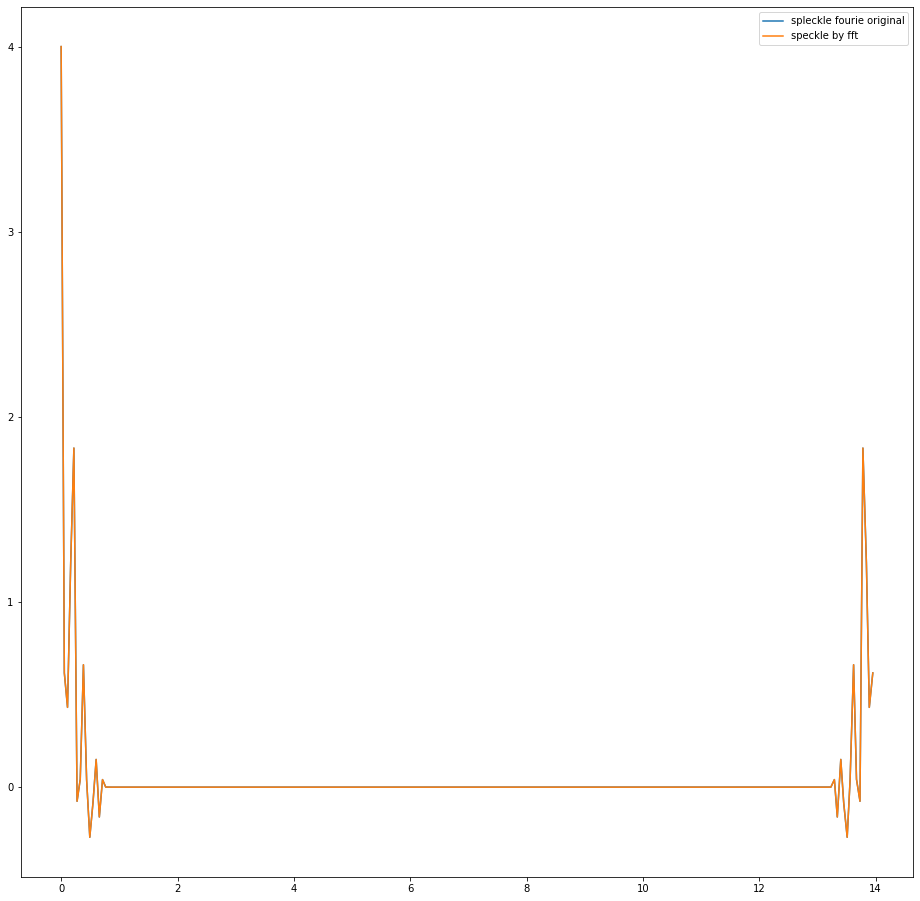

In [58]:
fig = plt.figure(figsize=(16,16))
plt.plot(x_axis, speckle_fou[0], label="spleckle fourie original")
plt.plot(x_axis, fft.fft(speckle_real[0])/256, label="speckle by fft")
plt.legend()
plt.show()

In [ ]:

n=np.asarray(n)

#now, we should have two arrays with shape (150 000*256,2) and (150 000*256)

#we should reshape those arrays in (150 000,256,2) and (150 000,256)

x=x[0:resolution] #the position array dim=(256,)

v=v.reshape(N_data,resolution)

n=n.reshape(N_data,resolution)



#Reading the ground state energy

#E=np.genfromtxt(e_filename,usecols=1)

E=np.asarray(E) #this is an array of dim=(150 000,